This notebook demonstrates the use of an Autoencoder model to generate digits from the MNIST dataset.

The encoder and the decoder are coded in a separete file and imported, they are available in the same directory as this notebook.

At the endof this notebook there is a widget that can be used to explore the 2-dimensional latent space to view generated images.

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_datasets as tfds

from encoder import Encoder
from decoder import Decoder

import numpy as np
import matplotlib.pyplot as plt

<b> Create the AE</b>

In [2]:
class AE:
    def __init__(self, z_dim):
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
        model_input = self.encoder.input
        model_output = self.decoder(self.encoder.output) # encoder output pased through the decoder
        
        self.model = Model(model_input, model_output)

<b> Prep the data</b>

In [3]:
(ds_train, ds_test_), ds_info = tfds.load('mnist', 
                              split=['train', 'test'], 
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)


batch_size = 256
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)

ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)

In [4]:
# return label for testing
def preprocess_with_label(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, label

ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

<b>Prepare model for training</b>

In [5]:
autoencoder = AE(z_dim=2)

In [6]:
model_path = "./models/autoencoder.h5"

checkpoint = ModelCheckpoint(model_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = False)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience = 5)

callbacks_list = [checkpoint, early]

autoencoder.model.compile(
    loss = "mse",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-4))
    #metrics=[tf.keras.losses.BinaryCrossentropy()])

<b>Train the model</b>

In [7]:
autoencoder.model.fit(ds_train, validation_data=ds_test, epochs=100, callbacks=callbacks_list)

Epoch 1/100
235/235 [==============================] - 7s 16ms/step - loss: 0.1064 - val_loss: 0.0603

Epoch 00001: val_loss improved from inf to 0.06028, saving model to ./models\autoencoder.h5
Epoch 2/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0594 - val_loss: 0.0566

Epoch 00002: val_loss improved from 0.06028 to 0.05658, saving model to ./models\autoencoder.h5
Epoch 3/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0563 - val_loss: 0.0547

Epoch 00003: val_loss improved from 0.05658 to 0.05471, saving model to ./models\autoencoder.h5
Epoch 4/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0546 - val_loss: 0.0530

Epoch 00004: val_loss improved from 0.05471 to 0.05303, saving model to ./models\autoencoder.h5
Epoch 5/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0526 - val_loss: 0.0512

Epoch 00005: val_loss improved from 0.05303 to 0.05118, saving model to ./models\autoencoder.h5
Epoch 6/1


Epoch 00045: val_loss improved from 0.04200 to 0.04199, saving model to ./models\autoencoder.h5
Epoch 46/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0421 - val_loss: 0.0419

Epoch 00046: val_loss improved from 0.04199 to 0.04195, saving model to ./models\autoencoder.h5
Epoch 47/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0421 - val_loss: 0.0421

Epoch 00047: val_loss did not improve from 0.04195
Epoch 48/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0420 - val_loss: 0.0424

Epoch 00048: val_loss did not improve from 0.04195
Epoch 49/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0420 - val_loss: 0.0416

Epoch 00049: val_loss improved from 0.04195 to 0.04161, saving model to ./models\autoencoder.h5
Epoch 50/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0419 - val_loss: 0.0419

Epoch 00050: val_loss did not improve from 0.04161
Epoch 51/100
235/235 [================

<ipython-input-8-aafc62f2ff13>:19: MatplotlibDeprecationWarning: 
The 'renderer' parameter of tight_layout() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'renderer', they should be passed as keyword, not positionally.
  f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)


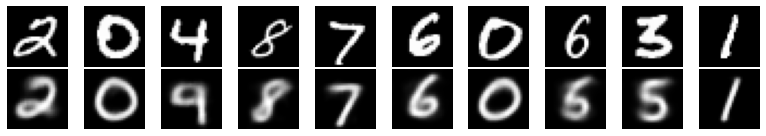

In [8]:
images, labels = next(iter(ds_test))
autoencoder.model = tf.keras.models.load_model(model_path)
outputs = autoencoder.model.predict(images)

# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i,:,:,0], cmap='gray')
        axarr[row+1,col].axis('off')        
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()

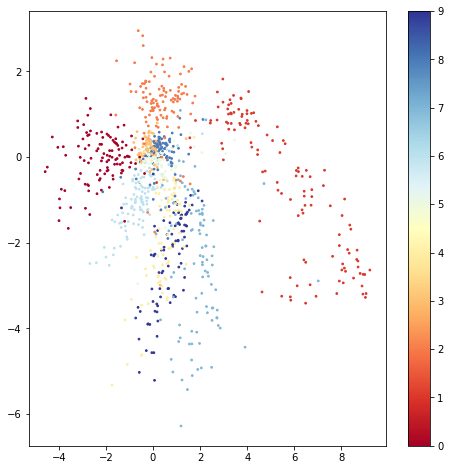

In [10]:
images, labels = next(iter(ds_test_label))
outputs = autoencoder.encoder.predict(images)
plt.figure(figsize=(8,8))
plt.scatter(outputs[:,0], outputs[:,1], c=labels, cmap='RdYlBu', s=3)
plt.colorbar()

Sweeping the 2D latent space to get an idea of the images generated in the given range

<ipython-input-12-c3385031f01f>:14: MatplotlibDeprecationWarning: 
The 'renderer' parameter of tight_layout() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'renderer', they should be passed as keyword, not positionally.
  f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)


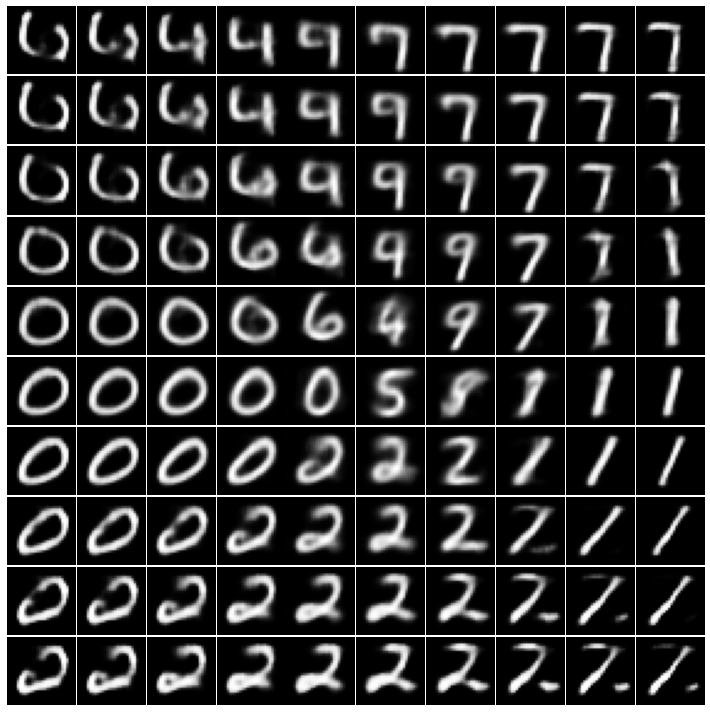

In [12]:
z_samples = np.array([[z1, z2] for z2 in np.arange(-5, 5, 1.) for z1 in np.arange(-5, 5, 1.)])
images = autoencoder.decoder.predict(z_samples)
grid_col = 10
grid_row = 10

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col, grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')   
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()

In [13]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

The Sliders can be used to explore the latent space to see what digit is represented given values for z1 and z2

In [19]:
@interact
def explore_latent_variable(z1 = (-5,5,0.1),
                            z2 = (-5,5,0.1)):
    z_samples = [[z1, z2]]
    images = autoencoder.decoder.predict(z_samples)
    plt.figure(figsize=(2,2))
    plt.imshow(images[0,:,:,0], cmap='gray')

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…